In [31]:
from core import history as ch
from core.fine_model import FineModel
import matplotlib as mpl
import matplotlib.pyplot as plt
import traceback
import warnings
import os

In [32]:
import analysis
import imp
imp.reload(analysis)
from analysis import analyze_lr, analyze_depth

In [33]:
_depth_key = 'EXP{:02}_D{:02}'
_fold_key = 'EXP{:02}_D{:02}_L{:02}_F{:02}'
_epoch_key = 'EXP{:02}_D{:02}_L{:02}_F{:02}_E{:03}'

Analyzing MobileNet(a=25) D=0, LR=0.0001


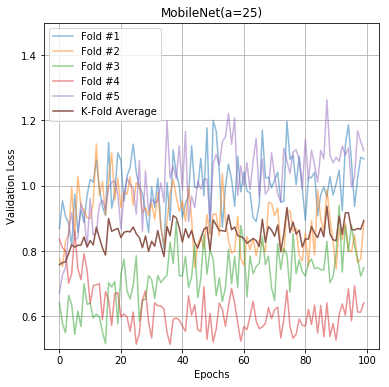

In [39]:
fm = FineModel.get_dict()['mobileneta25']()
verbose_model_name = 'MobileNet(a=25)'
metric='val_loss'
depth_index = 0
lr_index = 0
lr = 0.0001

analyze_lr(fm, verbose_model_name, depth_index=depth_index, lr_index=lr_index, lr_value=lr, metric=metric)

In [35]:
FineModel.get_dict().keys()

dict_keys(['xception', 'mobileneta25', 'mobilenetv2a35', 'vgg16', 'resnet50v2', 'inception_v3', 'inception_resnet_v2', 'densenet121', 'nasnet_mobile'])

Analyzing MobileNetV1 (a=0.25) D=0, LR=[0.001, 0.0001, 1e-05]


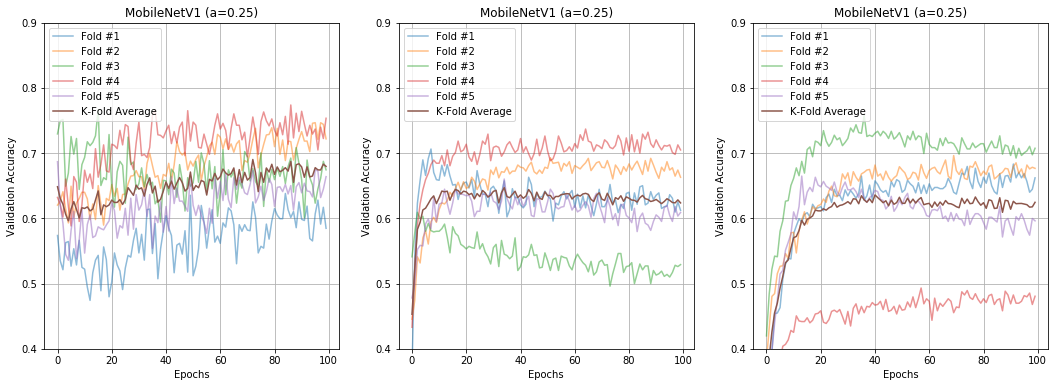

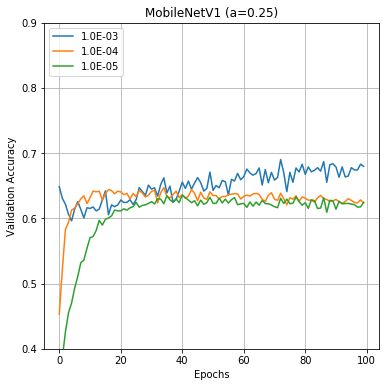

In [36]:
fm = FineModel.get_dict()['mobileneta25']()
verbose_model_name = 'MobileNetV1 (a=0.25)'
metric='val_acc'
depth_index = 0

analyze_depth(fm, verbose_model_name, depth_index=depth_index, metric=metric)